# Minimal reproducible example

This code is used for demonstration purposes only.


### Defining characteristics of the run.    
Model architecture, data, evaluation mode.    
    
The three evaluations were: CIFAR-10 to CIFAR-10-C; ImageNet-1K to ImageNet-1K-C; and Private Ultrasound to Public Ultrasound.    
Please note that the weights and images for the private ultrasound data are not available.

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch version:', torch.__version__)

#Overall configuration
batch_size = 500
weights_dir = '/path/to/weights/'
corruptions = ['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 
             'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 
             'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 
             'snow', 'spatter', 'speckle_noise', 'zoom_blur']


#Target dataset and adaptation configurations
eval_dataset = 'Ultrasound' # possible options are CIFAR-10, ImageNet-1K or Ultrasound.
adaptation = 'Hybrid-TTN' # possible options are None, TTN or Hybrid-TTN

severity = 5 # possible options are integers between 0 (no corruption in this case) and 5
corruption = corruptions[7] # For 'gaussian_noise'. If severity == 0, it doesn't matter
n_classes = 1 # number of selected classes for CIFAR or ImageNet.

PyTorch version: 2.0.0+cu117


### Creating model    
Loading weights, checking BatchNorm layers.

In [2]:
import create_model
ultrasound = False

if eval_dataset == 'CIFAR-10': 
    model_arch = 'Resnet-26'
    weights_path = weights_dir + 'cifar10_Resnet-26_weights.pth'

if eval_dataset == 'ImageNet-1K': 
    model_arch = 'Resnet-18'
    weights_path = None

if eval_dataset == 'Ultrasound':
    model_arch = 'Resnet-18'
    weights_path = weights_dir + 'ultrasound_ResNet18_weights.pth'
    ultrasound = True

net, _, _ = create_model.import_arch(model_arch, weights_path, device, ultrasound)

if adaptation == 'Hybrid-TTN':
    normnet, _, _ = create_model.model_adapt(net)

if adaptation == 'TTN':
    print('We are adapting the model with %s' % adaptation)

if adaptation == 'None':
    print('Running simple test mode, no test-time adaptation.')

==> Building model..
Weights loaded.
Model created: Resnet-18.
We are adapting the model with: Linear-Decay
Model adapted for threshold.


### Loading datasets    
Here we separate in different cells that will run depending on the dataset.

In [3]:
import import_dataset
import torchvision.models as models

print('Importing dataset:', eval_dataset)

if eval_dataset == 'CIFAR-10':
    dataloader = import_dataset.import_cifar(n_classes, corruption, severity)

if eval_dataset == 'ImageNet-1K':
    transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    dataloader = import_dataset.import_imagenet(n_classes, corruption, severity, transform)
    
if eval_dataset == 'Ultrasound':
    dataloader = import_dataset.import_US(target_dist='source', sample_seed = 81) #Options here are original, source, balanced, zeroes or ones

Importing dataset: Ultrasound
Finished preparing the sets.
Importing the images.
Finished preparing the dataloaders.
Using source distribution.


### Checking some images in the dataloader

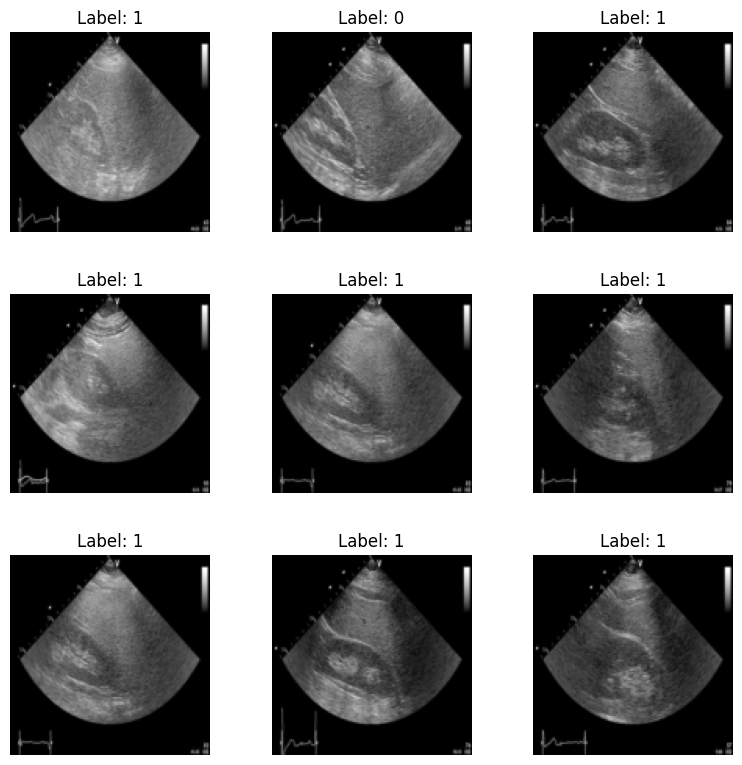

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

dataiter = iter(dataloader)
images, labels = next(dataiter)

# Create a 3x3 grid of images and labels
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.tight_layout()

for i in range(3):
    for j in range(3):
        # Plot the image
        n = random.randint(0,len(images)-1)
        img = images[n]
        img -= img.min()
        img /= img.max()
        axs[i][j].imshow(np.transpose(img, (1, 2, 0)))
        # Set the label as the title of the subplot
        if eval_dataset == 'CIFAR-10':
            classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            axs[i][j].set_title('Label: %s' % classes[labels[n].item()])
        else:
            axs[i][j].set_title('Label: %i' % labels[n].item())
        axs[i][j].axis('off')
plt.show()

### Running the test
Can be with or without adaptation.

In [5]:
import run_tests

if adaptation == 'None':
    run_tests.test(net, dataloader, device)

if adaptation == 'TTN':
    run_tests.TTN(net, dataloader, device)

if adaptation == 'Hybrid-TTN':
    run_tests.hybridTTN(net, normnet, dataloader, device)

Layer #: 1 out of 20
Adapting 100.0% of this layer (64 out of 64 channels)
Layer #: 2 out of 20
Adapting 94.7% of this layer (60 out of 64 channels)
Layer #: 3 out of 20
Adapting 89.5% of this layer (57 out of 64 channels)
Layer #: 4 out of 20
Adapting 84.2% of this layer (53 out of 64 channels)
Layer #: 5 out of 20
Adapting 78.9% of this layer (50 out of 64 channels)
Layer #: 6 out of 20
Adapting 73.7% of this layer (94 out of 128 channels)
Layer #: 7 out of 20
Adapting 68.4% of this layer (87 out of 128 channels)
Layer #: 8 out of 20
Adapting 63.2% of this layer (80 out of 128 channels)
Layer #: 9 out of 20
Adapting 57.9% of this layer (74 out of 128 channels)
Layer #: 10 out of 20
Adapting 52.6% of this layer (67 out of 128 channels)
Layer #: 11 out of 20
Adapting 47.4% of this layer (121 out of 256 channels)
Layer #: 12 out of 20
Adapting 42.1% of this layer (107 out of 256 channels)
Layer #: 13 out of 20
Adapting 36.8% of this layer (94 out of 256 channels)
Layer #: 14 out of 20
A